# Comparison of interpolation methods
We compare the results of our interpolation method versus reproject to verify the results.

In [1]:
from astropy.io import fits
import time
from reprojection.reproject import calculate_reprojection
from reproject import reproject_interp
from demo.create_test_data import create_test_fits_tiny
from matplotlib import pyplot as plt
import cmcrameri.cm as cmc
import numpy as np
import cv2

In [2]:
def align_and_diff(image1_array, image2_array, x_offset, y_offset):
    # Get dimensions of the first image (our target size)
    h1, w1 = image1_array.shape[:2]
    h2, w2 = image2_array.shape[:2]

    # Create a shifted version of image2 that matches the dimensions of image1
    shifted_img2 = np.zeros_like(image1_array)

    # Calculate the overlapping region coordinates
    # For image1
    x1_start = max(0, -x_offset)
    y1_start = max(0, -y_offset)
    x1_end = min(w1, w2 - x_offset) if x_offset < 0 else min(w1, w2 + x_offset)
    y1_end = min(h1, h2 - y_offset) if y_offset < 0 else min(h1, h2 + y_offset)

    # For image2
    x2_start = max(0, x_offset)
    y2_start = max(0, y_offset)
    x2_end = min(w2, w1 + x_offset) if x_offset > 0 else min(w2, w1 - x_offset)
    y2_end = min(h2, h1 + y_offset) if y_offset > 0 else min(h2, h1 - y_offset)

    # Calculate width and height of the overlapping region
    width = min(x1_end - x1_start, x2_end - x2_start)
    height = min(y1_end - y1_start, y2_end - y2_start)

    if width <= 0 or height <= 0:
        print("Warning: No overlap between images after alignment")
        return np.zeros_like(image1_array)

    # Copy the overlapping region from image2 to the shifted image
    shifted_img2[y1_start:y1_start+height, x1_start:x1_start+width] = \
        image2_array[y2_start:y2_start+height, x2_start:x2_start+width]
    # Calculate the difference
    difference = cv2.absdiff(image1_array, shifted_img2)

    return difference, shifted_img2

In [3]:
source_file, target_file = create_test_fits_tiny()
source_hdu = fits.open(source_file)[0]
target_hdu = fits.open(target_file)[0]

In [4]:
start = time.time()
reprojected_source_torch = calculate_reprojection(source_hdu, target_hdu, interpolation_mode="bicubic")
print(f"total time: {time.time()-start}")

total time: 0.41915178298950195


In [6]:
start = time.time()
reprojected_source_reproj = reproject_interp(source_hdu, source_hdu.header,order='bicubic')[0]
print(f"total time: {time.time()-start}")

total time: 0.025506019592285156


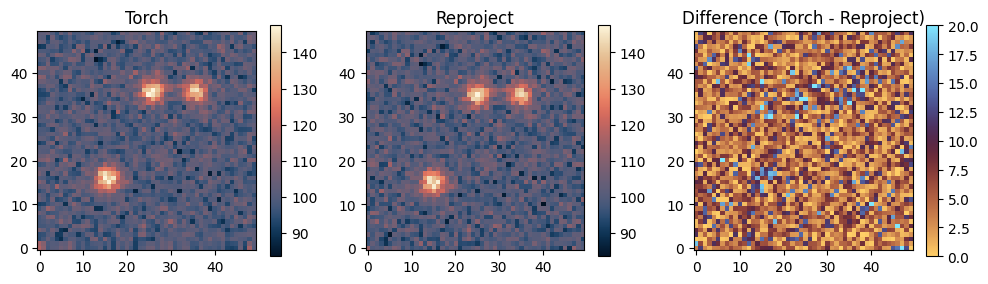

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12,6))
im1 = axs[0].imshow(reprojected_source_torch.cpu().numpy(), origin='lower', cmap=cmc.lipari)
axs[0].set_title("Torch")
plt.colorbar(im1, ax=axs[0], shrink=0.5)
im2 = axs[1].imshow(reprojected_source_reproj ,origin='lower', cmap=cmc.lipari)
axs[1].set_title("Reproject")
plt.colorbar(im1, ax=axs[1], shrink=0.5)

diff_result, _ = align_and_diff(reprojected_source_torch.cpu().numpy().astype(np.float32), reprojected_source_reproj.astype(np.float32), 0,0)
im3 = axs[2].imshow(diff_result ,origin='lower', cmap=cmc.managua, vmin=0, vmax=20)
axs[2].set_title("Difference (Torch - Reproject)")
plt.colorbar(im3, ax=axs[2], shrink=0.5)

As we can see the results are extremely similar. The differences are due to how the normalization is handled in our implementation versus reproject_interp.